# Churn Prediction for Banking Customers

>Ming Zhao
<br>
>October 10, 2021

### Project Goals

1. To identify customers who are likely to churn
2. To identify top factors that influence customer retention

### Dataset

https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers

### Outline

-   Data Cleaning   
-   Exploratory Data Analysis
    - Univariate
    - Bivariate
-   Feature Engineering
-   Modelling
    - Dataset Splitting
    - Model Training
        - **Logistic Regression**
        - **KNN**
        - **Random Forest**  
    - Model Selection
        - 5-Fold Cross Validation
        - Grid Search for Optimal Hyperparameters
    - Model Evaluation
        - Accuracy, Precision, Recall
        - ROC-AUC   
-   Feature Importance
    - Coefficient - Logistic Regression
    - Gini Importance - Random Forest
<br>

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings("ignore") 

***

## Data Cleaning

In [2]:
# Load data into dataframe
churn_df = pd.read_csv('Churn_Modelling.csv')

In [3]:
churn_df.shape

(10000, 14)

In [4]:
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Check data information
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
# Check missing values
churn_df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
# Check the unique values for each column
churn_df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

***

## Exploratory Data Analysis

### Univariate Analysis

In [8]:
# Check the value counts of y
print(churn_df['Exited'].value_counts())

# Check the value proportions of y
print(churn_df['Exited'].value_counts(normalize=True))

0    7963
1    2037
Name: Exited, dtype: int64
0    0.7963
1    0.2037
Name: Exited, dtype: float64


In [9]:
# Summarize continuous features
categorical = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
cat_df = churn_df[categorical].melt(value_name='value', var_name='var')
cat_df = cat_df.groupby(['var', 'value']).size().reset_index(name='count')
cat_df['percent'] = cat_df['count'].div(cat_df.groupby('var')['count'].transform('sum')).mul(100)
cat_df

,var,value,count,percent
0,Gender,Female,4543,45.43
1,Gender,Male,5457,54.57
2,Geography,France,5014,50.14
3,Geography,Germany,2509,25.09
4,Geography,Spain,2477,24.77
5,HasCrCard,0,2945,29.45
6,HasCrCard,1,7055,70.55
7,IsActiveMember,0,4849,48.49
8,IsActiveMember,1,5151,51.51


In [10]:
# Summarize continuous features
continuous = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts','Balance', 'EstimatedSalary']
churn_df[continuous].describe()

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,1.530200,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,0.581654,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,1.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,1.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,1.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,2.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,4.000000,250898.090000,199992.480000


### Bivariate Analysis

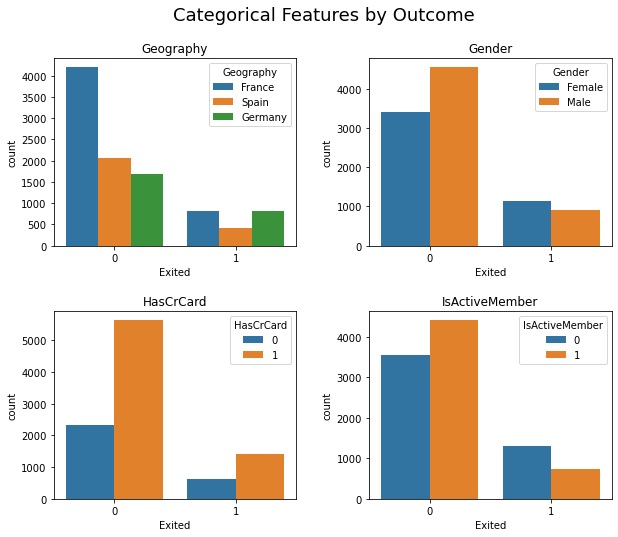

In [11]:
# barplot for categorical features vs. y
fig,axss = plt.subplots(2,2, figsize=[10,8])
sns.countplot(x='Exited', hue='Geography', data=churn_df, ax=axss[0][0]).set(title='Geography')
sns.countplot(x='Exited', hue='Gender', data=churn_df, ax=axss[0][1]).set(title='Gender')
sns.countplot(x='Exited', hue='HasCrCard', data=churn_df, ax=axss[1][0]).set(title='HasCrCard')
sns.countplot(x='Exited', hue='IsActiveMember', data=churn_df, ax=axss[1][1]).set(title='IsActiveMember')
plt.subplots_adjust(wspace=0.3, hspace=0.35, top=0.89)
fig.suptitle('Categorical Features by Outcome', fontsize=18)
plt.show()

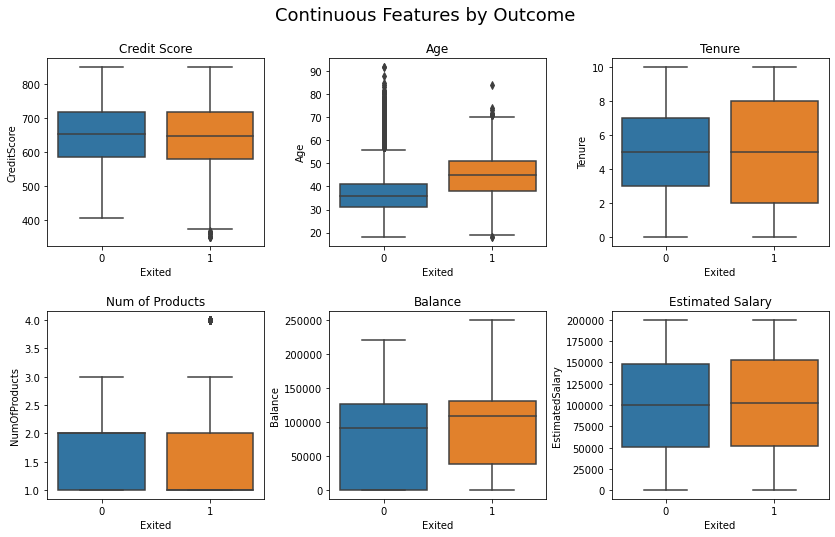

In [12]:
# boxplot for numerical features vs. y
fig,axss = plt.subplots(2,3, figsize=[14,8])
sns.boxplot(x='Exited', y ='CreditScore', data=churn_df, ax=axss[0][0]).set(title='Credit Score')
sns.boxplot(x='Exited', y ='Age', data=churn_df, ax=axss[0][1]).set(title='Age')
sns.boxplot(x='Exited', y ='Tenure', data=churn_df, ax=axss[0][2]).set(title='Tenure')
sns.boxplot(x='Exited', y ='NumOfProducts', data=churn_df, ax=axss[1][0]).set(title='Num of Products')
sns.boxplot(x='Exited', y ='Balance', data=churn_df, ax=axss[1][1]).set(title='Balance')
sns.boxplot(x='Exited', y ='EstimatedSalary', data=churn_df, ax=axss[1][2]).set(title='Estimated Salary')
plt.subplots_adjust(wspace=0.3, hspace=0.35, top=0.89)
fig.suptitle('Continuous Features by Outcome', fontsize=18)
plt.show()

In [13]:
# correlations between features
corr_score = churn_df[continuous].corr()
corr_score

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
CreditScore,1.000000,-0.003965,0.000842,0.012238,0.006268,-0.001384
Age,-0.003965,1.000000,-0.009997,-0.030680,0.028308,-0.007201
Tenure,0.000842,-0.009997,1.000000,0.013444,-0.012254,0.007784
NumOfProducts,0.012238,-0.030680,0.013444,1.000000,-0.304180,0.014204
Balance,0.006268,0.028308,-0.012254,-0.304180,1.000000,0.012797
EstimatedSalary,-0.001384,-0.007201,0.007784,0.014204,0.012797,1.000000


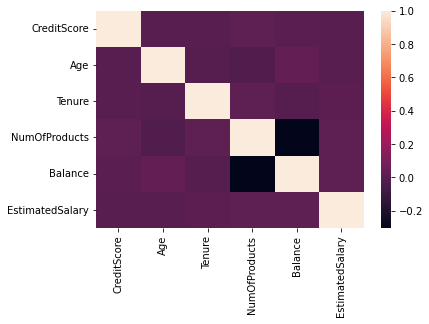

In [14]:
# heapmap of correlations
sns.heatmap(corr_score)
plt.show()

***

## Feature Engineering

In [15]:
# Drop useless features
to_drop = ['RowNumber','CustomerId','Surname']
data = churn_df.drop(to_drop, axis=1)

In [16]:
# ordinal encoding
data['Gender'] = np.where(data['Gender']=='Female', 1, 0)

# one-hot encoding
data = pd.get_dummies(data, drop_first=True)

In [17]:
# Obtain y
y = data['Exited']

# Obtain X
X = data.drop(['Exited'], axis=1)

# Obtain feature names
features = X.columns

In [18]:
# Standardize X
X = scale(X)

***

## Model Training and Evaluation

### Dataset Splitting

In [19]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=1)

print('Training set has ' + str(X_train.shape[0]) + ' observations with ' + str(X_train.shape[1]) + ' features')
print('Testing set has ' + str(X_test.shape[0]) + ' observations with ' + str(X_test.shape[1]) + ' features')

Training set has 8000 observations with 11 features
Testing set has 2000 observations with 11 features


### Model Training

#### Logistic Regression

In [20]:
# Initiate model
classifier_logistic = LogisticRegression(random_state=2021)

# Train model
classifier_logistic.fit(X_train, y_train)

LogisticRegression(random_state=2021)

In [21]:
# accuracy on training set
logit_accuracy = classifier_logistic.score(X_train, y_train)

print('Accuracy of logistic regression classifier on training set: {:.3f}'.format(logit_accuracy))

Accuracy of logistic regression classifier on training set: 0.811


#### KNN

In [22]:
# Initiate model
classifier_KNN = KNeighborsClassifier()

# Train model
classifier_KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [23]:
# accuracy on training set
knn_accuracy = classifier_KNN.score(X_train, y_train)

print('Accuracy of KNN classifier on training set: {:.3f}'.format(knn_accuracy))

Accuracy of KNN classifier on training set: 0.875


#### Random Forest

In [24]:
# Initiate model
classifier_RF = RandomForestClassifier(random_state=2021)

# Train model
classifier_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=2021)

In [25]:
# accuracy on training set
rf_accuracy = classifier_RF.score(X_train, y_train)

print('Accuracy of Random Forest classifier on training set: {:.3f}'.format(rf_accuracy))

Accuracy of Random Forest classifier on training set: 1.000


### Model Selection

#### 5-fold Cross Validation

*Note: <br>
cross validation -> model selection <br>
validation and training together -> parameters*

In [26]:
# 5-fold Cross Validation
model_names = ['Logistic Regression','K-nearest Neighbors','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]

# accuracy for different models
index = 0
for classifier in model_list:
    cv_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(cv_score.round(3))
    print('Average accuracy of ' + model_names[index] + ' on validation set is ' + str(cv_score.mean().round(3)))
    print('-----------------')
    index += 1

[0.819 0.809 0.806 0.806 0.816]
Average accuracy of Logistic Regression on validation set is 0.811
-----------------
[0.834 0.829 0.827 0.813 0.829]
Average accuracy of K-nearest Neighbors on validation set is 0.826
-----------------
[0.866 0.862 0.852 0.858 0.862]
Average accuracy of Random Forest on validation set is 0.86
-----------------


#### Grid Search for Optimal Hyperparameters

In [27]:
# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

Logistics regression

In [28]:
# Define parameters
parameters = {
    'penalty': ('none', 'l2'), 
    'C': (0.01, 0.1, 0.5, 1, 5),
    'solver': ('lbfgs', 'sag')
}

# Search for optimal hyperparameters
Grid_LR = GridSearchCV(LogisticRegression(random_state=2021),parameters, cv=5)

Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=2021),
             param_grid={'C': (0.01, 0.1, 0.5, 1, 5), 'penalty': ('none', 'l2'),
                         'solver': ('lbfgs', 'sag')})

In [29]:
print_grid_search_metrics(Grid_LR)

Best score: 0.811625
Best parameters set:
C:0.1
penalty:l2
solver:lbfgs


In [30]:
# best logistic regression
best_LR_model = Grid_LR.best_estimator_

KNN

In [31]:
# Define parameters
parameters = {
    'n_neighbors': (1, 5, 10, 15),
    'metric': ('euclidean', 'minkowski', 'cosine', 'manhattan')
}

# Search for optimal hyperparameters
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)

Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ('euclidean', 'minkowski', 'cosine',
                                    'manhattan'),
                         'n_neighbors': (1, 5, 10, 15)})

In [32]:
print_grid_search_metrics(Grid_KNN)

Best score: 0.8383750000000001
Best parameters set:
metric:cosine
n_neighbors:15


In [33]:
# best KNN
best_KNN_model = Grid_KNN.best_estimator_

Random Forest

In [34]:
# Define parameters
parameters = {
    'n_estimators': (10, 50, 100, 200),
    'max_samples': (50, 100, 1000),
    'max_features': ('sqrt', 'log2', 'None'),
    'criterion': ('entropy', 'gini', 'log_loss')
    
}

# Search for optimal hyperparameters
Grid_RF = GridSearchCV(RandomForestClassifier(random_state=2021),parameters, cv=5)

Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2021),
             param_grid={'criterion': ('entropy', 'gini', 'log_loss'),
                         'max_features': ('sqrt', 'log2', 'None'),
                         'max_samples': (50, 100, 1000),
                         'n_estimators': (10, 50, 100, 200)})

In [35]:
print_grid_search_metrics(Grid_RF)

Best score: 0.8641249999999999
Best parameters set:
criterion:gini
max_features:sqrt
max_samples:1000
n_estimators:200


In [36]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

### Model Evaluation

*TN: True negative  
FP: False positive  
FN: False negative  
TP: True positive*  

     |---------------------|
     |   Predicted Values  |
     |                     |
     |     0          1    |
     |---------------------|----------------------
     |    TN    |    FP    |  0                  |
     |          |          |      Actual Values  |
     |    FN    |    TP    |  1                  |
     ---------------------------------------------
                  
- Accuracy = (TP + TN) / (TP + FP + FN + TP)  
    - among all events, {} are predicted correctly
- Recall = TP / (TP + FN)  
    - among all positive actual events, {} are predicted correctly 
- Precision = TP / (TP + FP)
    - among all positive predicted events, {} were correct
    

#### Accuracy, Precision, Recall

In [37]:
# Predict outcomes on testing set
lr_y_pred = best_LR_model.predict(X_test)
knn_y_pred = best_KNN_model.predict(X_test)
rf_y_pred = best_RF_model.predict(X_test)

In [38]:
# evaluation function for accuracy, precision, recall
def cal_evaluation(classifier, conf_matrix):
    tn = conf_matrix[0][0]
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    tp = conf_matrix[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print ()
    print (classifier)
    print ("Accuracy is: " + str(accuracy.round(3)))
    print ("precision is: " + str(precision.round(3)))
    print ("recall is: " + str(recall.round(3)))

In [39]:
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test, lr_y_pred)),
    ("K Nearest Neighbors", confusion_matrix(y_test, knn_y_pred)),
    ("Random Forest", confusion_matrix(y_test, rf_y_pred))
]

for element in confusion_matrices:
    classifier, conf_matrix = element[0], element[1]
    cal_evaluation(classifier, conf_matrix)


Logistic Regression
Accuracy is: 0.81
precision is: 0.606
recall is: 0.197

K Nearest Neighbors
Accuracy is: 0.837
precision is: 0.704
recall is: 0.344

Random Forest
Accuracy is: 0.86
precision is: 0.793
recall is: 0.423


In [40]:
# Report classification results
print('Logistic Regression')
print(classification_report(y_test, lr_y_pred)[0:168])
print('K Nearest Neighbors')
print(classification_report(y_test, knn_y_pred)[0:168])
print('Random Forest')
print(classification_report(y_test, rf_y_pred)[0:168])

Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.61      0.20      0.30       407

    
K Nearest Neighbors
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1593
           1       0.70      0.34      0.46       407

    
Random Forest
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.79      0.42      0.55       407

    


#### ROC -AUC

In [41]:
# Predict probabilitis on testing set
lr_y_pred_prob = best_LR_model.predict_proba(X_test)[:,1] 
knn_y_pred_prob = best_KNN_model.predict_proba(X_test)[:,1] 
rf_y_pred_prob = best_RF_model.predict_proba(X_test)[:,1] 

In [42]:
# Calculate ROC, AUC
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_y_pred_prob)
lr_auc = auc(lr_fpr, lr_tpr)

knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_y_pred_prob)
knn_auc = auc(knn_fpr, knn_tpr)

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_y_pred_prob)
rf_auc = auc(rf_fpr, rf_tpr)

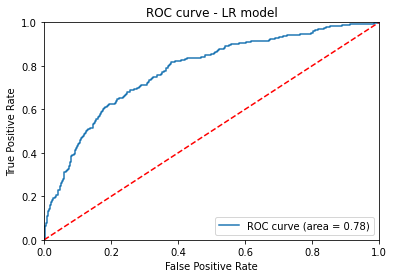

In [43]:
# ROC Curve
plt.figure()
plt.plot(lr_fpr, lr_tpr, label='ROC curve (area = %0.2f)' % lr_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - LR model')
plt.legend(loc="lower right")
plt.show()

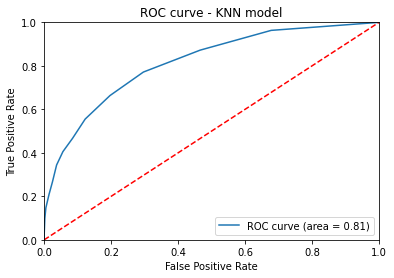

In [44]:
# ROC Curve
plt.figure()
plt.plot(knn_fpr, knn_tpr, label='ROC curve (area = %0.2f)' % knn_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - KNN model')
plt.legend(loc="lower right")
plt.show()

*

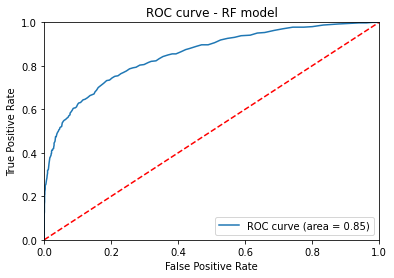

In [45]:
# ROC Curve
plt.figure()
plt.plot(rf_fpr, rf_tpr, label='ROC curve (area = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - RF model')
plt.legend(loc="lower right")
plt.show()

***

## Feature Discussion

### Feature Importance - Logistic Regression

In [46]:
# Check coefficients
coefs = best_LR_model.coef_[0]

# Print feature ranking
print ("Logistic Regression Coefficients")
indices = np.argsort(abs(coefs))[::-1] #DESC
for ind in range(X.shape[1]):
    print ("{0} : {1}".format(features[indices[ind]],round(coefs[indices[ind]], 4)))

Logistic Regression Coefficients
Age : 0.7391
IsActiveMember : -0.5224
Geography_Germany : 0.3474
Gender : 0.2586
Balance : 0.1344
CreditScore : -0.0582
NumOfProducts : -0.057
Tenure : -0.0378
Geography_Spain : 0.0308
EstimatedSalary : 0.0271
HasCrCard : -0.0149


In [47]:
# Assign features by +/-
coefficients = pd.Series(coefs, index=features)
coefs_df = pd.DataFrame(coefficients, columns=['coefs']).reset_index()

df_coefs = coefs_df.assign(type=lambda x: np.where(x.coefs < 0, "below", "above"))

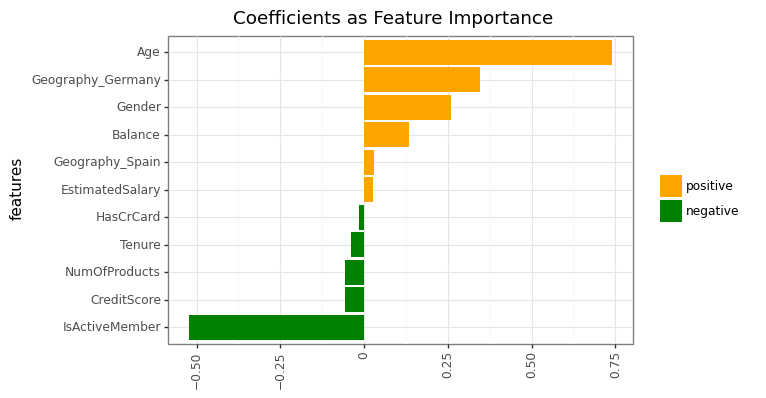

In [48]:
# Plot 
gg = p9.ggplot(df_coefs)
gg += p9.aes(x="reorder(index, coefs)", y="coefs")
gg += p9.geom_bar(stat="identity", mapping=p9.aes(fill="type"))
gg += p9.scale_fill_manual(name=" ", 
                           labels = ["positive", "negative"], 
                           values = {"above":"orange", "below":"green"})
gg += p9.coord_flip()
gg += p9.labels.ggtitle('Coefficients as Feature Importance')
gg += p9.xlab('features') + p9.ylab('')
gg += p9.theme_bw()
gg += p9.theme(axis_text_x = p9.element_text(angle=90))
gg += p9.theme(figure_size=(6, 4))
print(gg)

### Feature Importance - Random Forest

In [49]:
# Check Mean Decrease Impurity = gini importance
impts = best_RF_model.feature_importances_

# Print feature ranking
print("Random Forest Gini Importance:")
importances = pd.Series(impts, index=features)
importances.sort_values(ascending=False)

# indices = np.argsort(impts)[::-1] #DESC
# for ind in range(X.shape[1]):
#     print ("{0} : {1}".format(features[indices[ind]],round(impts[indices[ind]], 4)))

Random Forest Gini Importance:


Age                  0.234175
EstimatedSalary      0.140344
CreditScore          0.139688
Balance              0.134943
NumOfProducts        0.127572
Tenure               0.084164
IsActiveMember       0.044190
Geography_Germany    0.032231
Gender               0.025362
HasCrCard            0.020704
Geography_Spain      0.016627
dtype: float64

In [50]:
# Sort gini importance
gini_df = pd.DataFrame(importances, columns=['gini']).reset_index()
gini_df = gini_df.sort_values(by='gini', ascending=False)

gini_list = gini_df['index'].tolist()
gini = pd.Categorical(gini_df['index'], categories=gini_list)
df_gini = gini_df.assign(index = gini)

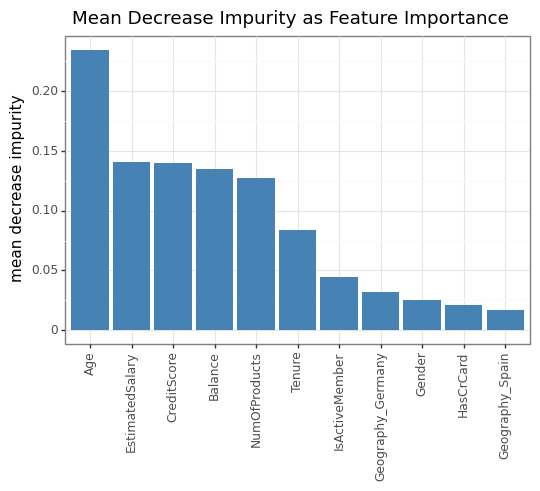

In [51]:
# Plot 
gg = p9.ggplot(df_gini)
gg += p9.aes(x='index', y='gini')
gg += p9.geom_bar(stat="identity", fill="steelblue")
gg += p9.labels.ggtitle('Mean Decrease Impurity as Feature Importance')
gg += p9.xlab('') + p9.ylab('mean decrease impurity')
gg += p9.theme_bw()
gg += p9.theme(axis_text_x = p9.element_text(angle=90))
gg += p9.theme(figure_size=(6, 4))
print(gg)

In [52]:
print ("Top 5 important features for logistic regression: \n {0}".format(features[indices[0:5]].tolist()))

Top 5 important features for logistic regression: 
 ['Age', 'IsActiveMember', 'Geography_Germany', 'Gender', 'Balance']


In [53]:
print ("Top 5 important features for random forest: \n {0}".format(gini_list[0:5]))

Top 5 important features for random forest: 
 ['Age', 'EstimatedSalary', 'CreditScore', 'Balance', 'NumOfProducts']


<br>

<br>